In [1]:
import polars as pl 
import sys
from pathlib import Path
import importlib
import matplotlib.pyplot as plt
import numpy as np 
from collections import Counter

# Set the font family to Arial
# https://g.co/gemini/share/3898a74b2d77
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.sans-serif'] = ['Arial'] # Add Arial to the sans-serif list

plt.rcParams.update({
    'font.size': 20,
})

REFERENCE_GENOME = "hg38"
TILE_SIZE = 1000
METH_READ_PHASED_DIR = Path('/scratch/ucgd/lustre-labs/quinlan/data-shared/dna-methylation/CEPH1463.GRCh38.hifi.founder-phased.all-cpgs')
SAMPLE = '200105' # 'NA12878' # '200081' 
BED_METH = f"{METH_READ_PHASED_DIR}/{SAMPLE}.dna-methylation.founder-phased.all_cpgs.sorted.bed.gz"

REPO_DIR = Path("/scratch/ucgd/lustre-labs/quinlan/u6018199/tapestry")
sys.path.append(str(REPO_DIR / "src" / "util"))
sys.path.append(f"{REPO_DIR}/src") 

DELTA_METH_THRESHOLD = 0.9

pl.Config.set_tbl_rows(10) 

polars.config.Config

## Tile the genome 

In [2]:
import tile
importlib.reload(tile)
from tile import get_tiles 

DF_TILES = get_tiles(REFERENCE_GENOME, TILE_SIZE)
DF_TILES

chrom,start,end
str,i64,i64
"""chr1""",0,1000
"""chr1""",1000,2000
"""chr1""",2000,3000
"""chr1""",3000,4000
"""chr1""",4000,5000
…,…,…
"""chrM""",11000,12000
"""chrM""",12000,13000
"""chrM""",13000,14000


## Fetch phased and unphased DNA methylation at all CpG sites in the reference and sample genome

In [3]:
import read_data
importlib.reload(read_data)
from read_data import read_tapestry

DF_METH = read_tapestry(BED_METH)
DF_METH.sample(10)

chrom,start,end,total_read_count,methylation_level_count,methylation_level_model,start_hap_map_block,end_hap_map_block,haplotype_concordance_in_hap_map_block,num_het_SNVs_in_hap_map_block,total_read_count_pat,total_read_count_mat,founder_haplotype_pat,founder_haplotype_mat,methylation_level_pat_count,methylation_level_mat_count,methylation_level_pat_model,methylation_level_mat_model,cpg_is_within_50bp_of_mismatch_site,cpg_overlaps_at_least_one_snv,snv_genotypes,cpg_is_allele_specific
str,i64,i64,i64,f64,f64,i64,i64,f64,i64,i64,i64,str,str,f64,f64,f64,f64,bool,bool,str,bool
"""chr1""",234471646,234471648,42,0.857,0.961,null,null,null,null,null,null,null,null,null,null,null,null,false,false,""".""",false
"""chr18""",72190281,72190283,61,0.803,0.873,71950588,72438790,1.0,138,23,38,"""I""","""D""",0.696,0.868,0.79,0.927,false,false,""".""",false
"""chr14""",73307880,73307882,34,0.882,0.951,72601007,73599985,1.0,583,20,14,"""K""","""C""",0.8,1.0,0.916,0.964,false,false,""".""",false
"""chr1""",3466895,3466897,23,0.913,0.954,3399126,3468692,1.0,62,12,11,"""E""","""C""",0.917,0.909,0.958,0.959,false,false,""".""",false
"""chr10""",113568838,113568840,39,0.821,0.936,113507189,113983134,1.0,391,19,20,"""K""","""C""",0.789,0.85,0.893,0.956,false,false,""".""",false
"""chr6""",110876765,110876767,53,0.302,0.027,110327320,111085275,1.0,875,29,24,"""K""","""C""",0.276,0.333,0.042,0.023,false,false,""".""",false
"""chr12""",129536603,129536605,43,0.791,0.925,129452214,129933616,1.0,508,23,20,"""I""","""C""",0.783,0.8,0.921,0.921,false,false,""".""",false
"""chr1""",211081260,211081262,35,0.857,0.903,210709048,211160064,1.0,426,18,17,"""I""","""C""",0.889,0.824,0.95,0.835,false,false,""".""",false
"""chr18""",23274519,23274521,46,0.674,0.932,null,null,null,null,null,null,null,null,null,null,null,null,false,false,""".""",false


## Filter out allele-specific CpG sites as these can masqeurade as imprinted loci 

In [4]:
# Notice the values of "0.0" for count-based methylation on one of the haplotypes in this filter: 
DF_METH.filter(pl.col('cpg_is_allele_specific')).sample(10)

chrom,start,end,total_read_count,methylation_level_count,methylation_level_model,start_hap_map_block,end_hap_map_block,haplotype_concordance_in_hap_map_block,num_het_SNVs_in_hap_map_block,total_read_count_pat,total_read_count_mat,founder_haplotype_pat,founder_haplotype_mat,methylation_level_pat_count,methylation_level_mat_count,methylation_level_pat_model,methylation_level_mat_model,cpg_is_within_50bp_of_mismatch_site,cpg_overlaps_at_least_one_snv,snv_genotypes,cpg_is_allele_specific
str,i64,i64,i64,f64,f64,i64,i64,f64,i64,i64,i64,str,str,f64,f64,f64,f64,bool,bool,str,bool
"""chr3""",127121451,127121453,34,0.382,0.474,127063511,128050169,1.0,854,14,20,"""E""","""D""",0.929,0.0,0.937,0.057,false,true,"""het""",true
"""chr2""",90395818,90395820,179,0.587,0.656,89754085,90402254,0.854651,172,49,107,"""G""","""C""",0.837,0.495,0.877,0.604,false,true,"""het""",true
"""chr18""",50872495,50872497,51,0.373,0.534,50688889,51041901,1.0,313,28,23,"""I""","""D""",0.0,0.826,0.054,0.913,false,true,"""het""",true
"""chr5""",154195638,154195640,35,0.543,0.633,153639603,154456426,1.0,930,16,19,"""K""","""C""",0.0,1.0,0.053,0.955,false,true,"""het""",true
"""chr10""",70621395,70621397,43,0.605,0.57,70440448,70823182,1.0,505,27,16,"""K""","""C""",0.963,0.0,0.965,0.061,false,true,"""het""",true
"""chr3""",8921039,8921041,45,0.511,0.529,8607574,9183767,1.0,943,31,14,"""E""","""D""",0.742,0.0,0.952,0.06,false,true,"""het""",true
"""chr8""",28901699,28901701,50,0.4,0.538,28420100,29431282,0.591358,810,26,24,"""I""","""D""",0.769,0.0,0.951,0.056,false,true,"""het""",true
"""chr12""",123218218,123218220,38,0.395,0.524,122772887,124066612,0.988593,1052,22,16,"""I""","""C""",0.0,0.938,0.061,0.964,false,true,"""het""",true
"""chr14""",25290408,25290410,49,0.245,0.388,25164893,25412638,1.0,383,23,26,"""E""","""D""",0.522,0.0,0.622,0.064,false,true,"""het""",true


In [5]:
DF_METH_FREE_FROM_ALLELE_SPECIFIC_CPGS = DF_METH.filter(~pl.col('cpg_is_allele_specific'))

## Compute difference in methylation between haplotypes in tiles that harbor at least one CpG (in reference or sample genome)

In [6]:
import methylation
importlib.reload(methylation)
from methylation import compute_methylation

DF_TILES_WITH_METH = compute_methylation(DF_TILES, DF_METH_FREE_FROM_ALLELE_SPECIFIC_CPGS)
print(len(DF_TILES_WITH_METH))
DF_TILES_WITH_METH.sample(10)

2899884


chrom,start,end,num_cpgs,founder_pat,founder_mat,count_based_meth,num_cpgs_with_non_null_count_based_meth,model_based_meth,count_based_meth_pat,num_cpgs_with_non_null_count_based_meth_pat,model_based_meth_pat,count_based_meth_mat,num_cpgs_with_non_null_count_based_meth_mat,model_based_meth_mat
str,i64,i64,u32,list[str],list[str],f64,u32,f64,f64,u32,f64,f64,u32,f64
"""chr15""",23052000,23053000,8,"[""I""]","[""D""]",0.634,8,0.7745,0.6845,8,0.8825,0.5585,8,0.67475
"""chr5""",12951000,12952000,2,"[""G""]","[""D""]",0.8035,2,0.9075,0.769,2,0.868,0.8335,2,0.933
"""chr8""",98932000,98933000,4,"[""I""]","[""D""]",0.6905,4,0.7935,0.7815,4,0.91075,0.6045,4,0.6765
"""chr9""",35482000,35483000,8,"[""E""]","[""C""]",0.81425,8,0.90725,0.7885,8,0.8575,0.844875,8,0.94125
"""chr6""",157332000,157333000,9,"[""K""]","[""C""]",0.768333,9,0.883444,0.743556,9,0.859444,0.795444,9,0.890556
"""chr11""",17798000,17799000,10,[null],[null],0.7834,10,0.9517,null,0,null,null,0,null
"""chr13""",21929000,21930000,22,"[""K"", null]","[""C"", null]",0.764619,21,0.906762,0.790714,21,0.902143,0.751095,21,0.898286
"""chr4""",124300000,124301000,7,"[""I""]","[""D""]",0.830143,7,0.932714,0.849286,7,0.931857,0.818429,7,0.927143
"""chr7""",98248000,98249000,20,[null],[null],0.75465,20,0.87285,null,0,null,null,0,null


Text(0, 0.5, 'Number of tiles')

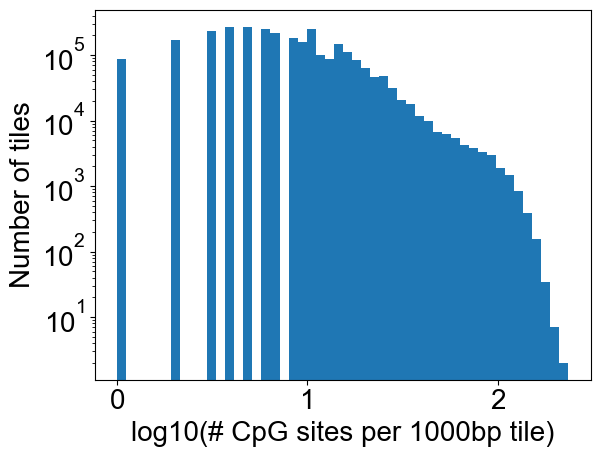

In [7]:
plt.hist(
    np.log10(DF_TILES_WITH_METH["num_cpgs"]), 
    bins=50, # type: ignore
    alpha=None, 
    label=None,
    color=None
)
plt.xscale('linear')
plt.yscale('log')
plt.xlabel(f'log10(# CpG sites per {TILE_SIZE}bp tile)')
plt.ylabel('Number of tiles')

In [8]:
import imprinting
importlib.reload(imprinting)
from imprinting import compute_delta_methylation

DF_TILES_WITH_DELTA_METH = compute_delta_methylation(DF_TILES_WITH_METH)
print(len(DF_TILES_WITH_DELTA_METH))
DF_TILES_WITH_DELTA_METH.sample(10)

2899884


chrom,start,end,num_cpgs,founder_pat,founder_mat,num_cpgs_with_non_null_count_based_meth,count_based_meth_pat,num_cpgs_with_non_null_count_based_meth_pat,model_based_meth_pat,count_based_meth_mat,num_cpgs_with_non_null_count_based_meth_mat,model_based_meth_mat,delta_of_count_based_meth,delta_of_model_based_meth
str,i64,i64,u32,list[str],list[str],u32,f64,u32,f64,f64,u32,f64,f64,f64
"""chr12""",9178000,9179000,10,[null],[null],10,null,0,null,null,0,null,null,null
"""chr11""",314000,315000,27,"[""E"", null]","[""C"", null]",27,null,0,null,0.147059,17,0.062647,null,null
"""chr1""",80743000,80744000,22,"[""E""]","[""D""]",22,0.7895,22,0.914136,0.782864,22,0.901818,0.006636,0.012318
"""chr1""",79321000,79322000,4,"[""E""]","[""D""]",4,0.8,4,0.9155,0.73225,4,0.80425,0.06775,0.11125
"""chr3""",82664000,82665000,8,"[""E""]","[""C""]",8,0.671625,8,0.792625,0.770875,8,0.93625,-0.09925,-0.143625
"""chr22""",43679000,43680000,5,"[""E""]","[""C""]",5,0.7578,5,0.8326,0.771,5,0.8848,-0.0132,-0.0522
"""chr14""",93992000,93993000,12,"[""K""]","[""C""]",12,0.793583,12,0.91475,0.72075,12,0.817167,0.072833,0.097583
"""chr5""",54534000,54535000,8,"[""G""]","[""D""]",8,0.759375,8,0.8995,0.734625,8,0.878,0.02475,0.0215
"""chr1""",75800000,75801000,6,[null],[null],6,null,0,null,null,0,null,null,null
